# CartPole Reinforcement Learning

This notebook implements the CartPole environment and solves it using three Reinforcement Learning algorithms:
1. Q-Learning
2. SARSA
3. Monte Carlo (First-Visit On-Policy)

The implementation mirrors the logic from the web-based simulator.

In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

## 1. CartPole Environment

We define the `CartPole` class with the physics dynamics and a `discretize_state` function to map continuous states to discrete bins.

In [2]:
class CartPole:
    def __init__(self):
        self.gravity = 9.8
        self.mass_cart = 1.0
        self.mass_pole = 0.1
        self.total_mass = self.mass_cart + self.mass_pole
        self.length = 0.5  # Half the pole's length
        self.polemass_length = self.mass_pole * self.length
        self.force_mag = 10.0
        self.tau = 0.02  # Seconds between state updates
        self.theta_threshold_radians = 12 * 2 * math.pi / 360
        self.x_threshold = 2.4
        self.reset()

    def reset(self):
        # Random start state: uniform random between -0.05 and 0.05
        self.x = random.uniform(-0.05, 0.05)
        self.x_dot = random.uniform(-0.05, 0.05)
        self.theta = random.uniform(-0.05, 0.05)
        self.theta_dot = random.uniform(-0.05, 0.05)
        self.steps = 0
        return (self.x, self.x_dot, self.theta, self.theta_dot)

    def step(self, action):
        # Action 0: Left, Action 1: Right
        force = self.force_mag if action == 1 else -self.force_mag
        costheta = math.cos(self.theta)
        sintheta = math.sin(self.theta)

        temp = (force + self.polemass_length * self.theta_dot**2 * sintheta) / self.total_mass
        theta_acc = (self.gravity * sintheta - costheta * temp) / (self.length * (4.0 / 3.0 - self.mass_pole * costheta**2 / self.total_mass))
        x_acc = temp - self.polemass_length * theta_acc * costheta / self.total_mass

        self.x += self.tau * self.x_dot
        self.x_dot += self.tau * x_acc
        self.theta += self.tau * self.theta_dot
        self.theta_dot += self.tau * theta_acc

        self.steps += 1

        done = (self.x < -self.x_threshold or self.x > self.x_threshold or
                self.theta < -self.theta_threshold_radians or self.theta > self.theta_threshold_radians)

        reward = 0 if done else 1

        return (self.x, self.x_dot, self.theta, self.theta_dot), reward, done

def discretize_state(state):
    x, x_dot, theta, theta_dot = state

    # Discretize x (Cart Position) - 3 bins
    if x < -0.8: x_bin = 0
    elif x < 0.8: x_bin = 1
    else: x_bin = 2

    # Discretize x_dot (Cart Velocity) - 3 bins
    if x_dot < -0.5: x_dot_bin = 0
    elif x_dot < 0.5: x_dot_bin = 1
    else: x_dot_bin = 2

    # Discretize Theta (Angle) - 12 bins
    if theta < -0.20: theta_bin = 0
    elif theta < -0.15: theta_bin = 1
    elif theta < -0.10: theta_bin = 2
    elif theta < -0.05: theta_bin = 3
    elif theta < -0.02: theta_bin = 4
    elif theta < 0: theta_bin = 5
    elif theta < 0.02: theta_bin = 6
    elif theta < 0.05: theta_bin = 7
    elif theta < 0.10: theta_bin = 8
    elif theta < 0.15: theta_bin = 9
    elif theta < 0.20: theta_bin = 10
    else: theta_bin = 11

    # Discretize ThetaDot (Angular Velocity) - 6 bins
    if theta_dot < -1.5: theta_dot_bin = 0
    elif theta_dot < -0.5: theta_dot_bin = 1
    elif theta_dot < 0: theta_dot_bin = 2
    elif theta_dot < 0.5: theta_dot_bin = 3
    elif theta_dot < 1.5: theta_dot_bin = 4
    else: theta_dot_bin = 5

    return (x_bin, x_dot_bin, theta_bin, theta_dot_bin)

## 2. RL Utility Functions

Helper functions for initializing the Q-table, getting Q-values, and epsilon-greedy action selection.

In [3]:
def init_Q():
    return {}  # Sparse initialization using a dictionary

def get_Q(Q, state_key):
    if state_key not in Q:
        Q[state_key] = [0.0, 0.0]  # Initialize with 0s for 2 actions
    return Q[state_key]

def eps_greedy(Q, state_key, epsilon):
    if random.random() < epsilon:
        return random.randint(0, 1)
    
    values = get_Q(Q, state_key)
    # Random tie-breaking
    if values[0] == values[1]:
        return random.randint(0, 1)
    return 0 if values[0] > values[1] else 1

## 3. Algorithms

### Q-Learning

In [4]:
def train_q_learning(env, alpha=0.1, gamma=0.99, episodes=1000):
    Q = init_Q()
    steps_per_episode = []
    
    min_epsilon = 0.01
    max_epsilon = 1.0
    max_steps = 500
    
    for ep in range(episodes):
        # Linear decay over first 50% of episodes
        decay_ratio = min(1.0, ep / (episodes * 0.5))
        epsilon = max(min_epsilon, max_epsilon - decay_ratio * (max_epsilon - min_epsilon))
        
        state = env.reset()
        state_key = discretize_state(state)
        done = False
        steps = 0
        
        while not done and steps < max_steps:
            action = eps_greedy(Q, state_key, epsilon)
            next_state, reward, done = env.step(action)
            
            next_key = discretize_state(next_state)
            next_values = get_Q(Q, next_key)
            max_next = max(next_values)
            
            current_values = get_Q(Q, state_key)
            current_values[action] += alpha * (reward + gamma * max_next - current_values[action])
            
            state = next_state
            state_key = next_key
            steps += 1
            
        steps_per_episode.append(steps)
        
    return Q, steps_per_episode

### SARSA

In [5]:
def train_sarsa(env, alpha=0.1, gamma=0.99, episodes=1000):
    Q = init_Q()
    steps_per_episode = []
    
    min_epsilon = 0.01
    max_epsilon = 1.0
    max_steps = 500
    
    for ep in range(episodes):
        decay_ratio = min(1.0, ep / (episodes * 0.5))
        epsilon = max(min_epsilon, max_epsilon - decay_ratio * (max_epsilon - min_epsilon))
        
        state = env.reset()
        state_key = discretize_state(state)
        action = eps_greedy(Q, state_key, epsilon)
        done = False
        steps = 0
        
        while not done and steps < max_steps:
            next_state, reward, done = env.step(action)
            next_key = discretize_state(next_state)
            next_action = eps_greedy(Q, next_key, epsilon)
            
            current_values = get_Q(Q, state_key)
            next_values = get_Q(Q, next_key)
            
            current_values[action] += alpha * (reward + gamma * next_values[next_action] - current_values[action])
            
            state = next_state
            state_key = next_key
            action = next_action
            steps += 1
            
        steps_per_episode.append(steps)
        
    return Q, steps_per_episode

### Monte Carlo

In [6]:
def train_monte_carlo(env, gamma=0.99, episodes=1000):
    Q = init_Q()
    returns_sum = {}
    returns_count = {}
    steps_per_episode = []
    
    min_epsilon = 0.01
    max_epsilon = 1.0
    max_steps = 500
    
    for ep in range(episodes):
        decay_ratio = min(1.0, ep / (episodes * 0.5))
        epsilon = max(min_epsilon, max_epsilon - decay_ratio * (max_epsilon - min_epsilon))
        
        state = env.reset()
        state_key = discretize_state(state)
        episode_data = []
        done = False
        steps = 0
        
        # Generate Episode
        while not done and steps < max_steps:
            action = eps_greedy(Q, state_key, epsilon)
            next_state, reward, done = env.step(action)
            episode_data.append((state_key, action, reward))
            
            state = next_state
            state_key = discretize_state(state)
            steps += 1
            
        steps_per_episode.append(steps)
        
        # Update Q-values
        G = 0
        visited = set()
        for i in range(len(episode_data) - 1, -1, -1):
            s, a, r = episode_data[i]
            G = gamma * G + r
            
            if (s, a) not in visited:
                visited.add((s, a))
                if (s, a) not in returns_sum:
                    returns_sum[(s, a)] = 0
                    returns_count[(s, a)] = 0
                
                returns_sum[(s, a)] += G
                returns_count[(s, a)] += 1
                
                q_vals = get_Q(Q, s)
                q_vals[a] = returns_sum[(s, a)] / returns_count[(s, a)]
                
    return Q, steps_per_episode

## 4. Training and Visualization

We will now train all three agents and compare their performance.

Training Q-Learning...
Training SARSA...
Training Monte Carlo...


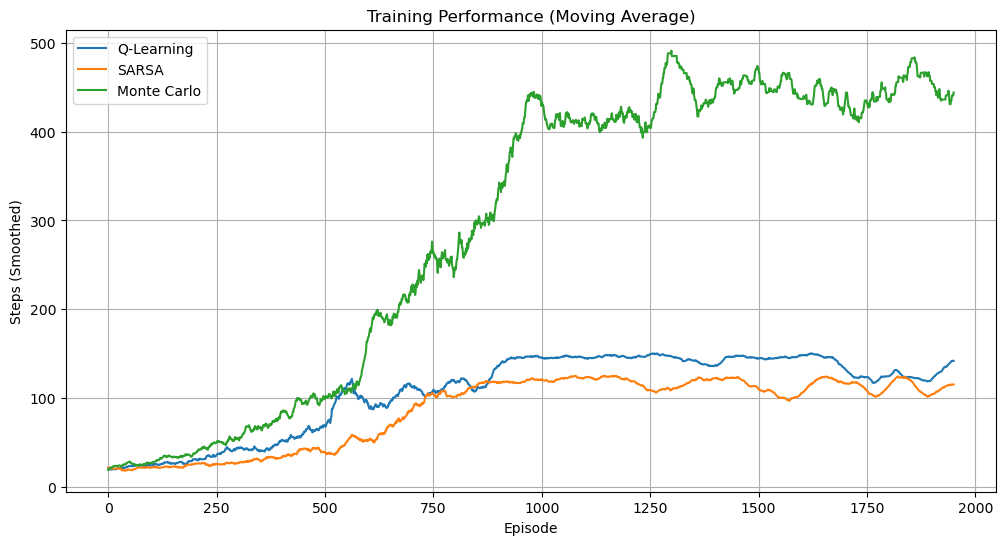

In [7]:
episodes = 2000
env = CartPole()

print("Training Q-Learning...")
q_Q, q_steps = train_q_learning(env, episodes=episodes)

print("Training SARSA...")
sarsa_Q, sarsa_steps = train_sarsa(env, episodes=episodes)

print("Training Monte Carlo...")
mc_Q, mc_steps = train_monte_carlo(env, episodes=episodes)

# Smoothing function for plots
def moving_average(data, window_size=50):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(12, 6))
plt.plot(moving_average(q_steps), label='Q-Learning')
plt.plot(moving_average(sarsa_steps), label='SARSA')
plt.plot(moving_average(mc_steps), label='Monte Carlo')
plt.xlabel('Episode')
plt.ylabel('Steps (Smoothed)')
plt.title('Training Performance (Moving Average)')
plt.legend()
plt.grid(True)
plt.show()